In [2]:
import pandas as pd
import numpy as np
import os
from roboflow import Roboflow
import seaborn as sns



**Collect the data**

In [3]:

rf = Roboflow(api_key="91wRcVQaXn0dpCrfb6Y8")
project = rf.workspace("roboflow-100").project("construction-safety-gsnvb")
version = project.version(1)
dataset = version.download("yolov8")
path = ("PPE_Detection\construction-safety-1")

invalid escape sequence '\c'
invalid escape sequence '\c'
invalid escape sequence '\c'


loading Roboflow workspace...
loading Roboflow project...


In [4]:
path = ("../PPE_Detection/construction-safety-1")
# check if the path exists
if not os.path.exists(path):
    print("Path does not exist")

# check what is in the path
print(os.listdir(path))

DATASET_PATH = path
IMAGES_DIR = os.path.join(DATASET_PATH, "train/images")
LABELS_DIR = os.path.join(DATASET_PATH, "train/labels")

['augmented_train', 'data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


The dataset contains a "None" class, which does not bring any value to the final model. 
The decision is to drop it

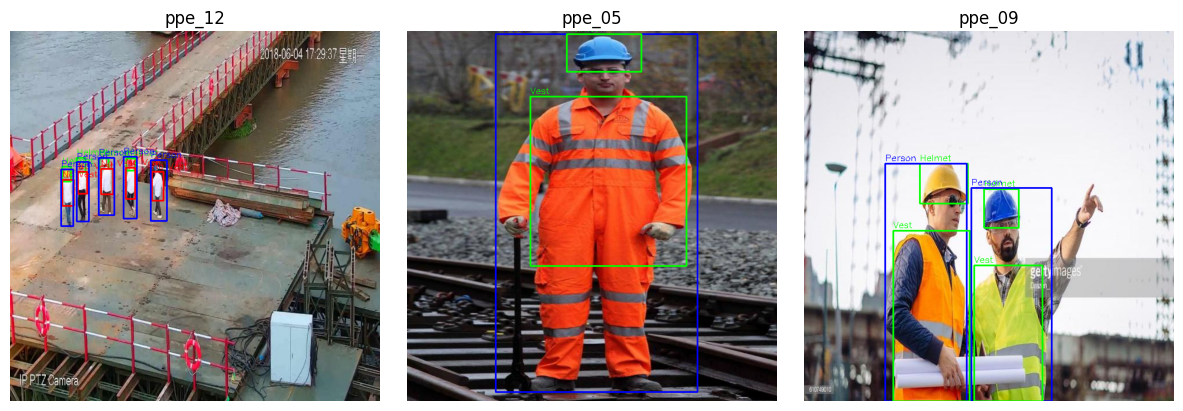

In [5]:
import cv2
import matplotlib.pyplot as plt

# helmet
# no-helmet
# no-vest
# person
# vest 
CLASS_MAP = {
    0: 'Helmet',
    1: 'No Helmet',
    2: 'No Vest',
    3: 'Person',
    4: 'Vest'
}

def visualize_batch_on_grid(split='train', num_images=10):
    images_dir = os.path.join(DATASET_PATH, split, 'images')
    labels_dir = os.path.join(DATASET_PATH, split, 'labels')

    all_images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        num_images = len(all_images)

    sample_images = np.random.choice(all_images, num_images, replace=False)

    # Set up the plot grid (2 rows, 5 columns for 10 images)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    axes = axes.flatten()

    for idx, sample_image_name in enumerate(sample_images):
        sample_image_path = os.path.join(images_dir, sample_image_name)

        if not os.path.exists(sample_image_path):
            print(f"Image not found: {sample_image_name}")
            continue

        # Load image
        sample_image = cv2.imread(sample_image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        # Load label
        label_path = os.path.join(labels_dir, sample_image_name.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        if not os.path.exists(label_path):
            print(f"Label not found for {sample_image_name}")
            continue

        h, w, _ = sample_image.shape

        # Draw bounding boxes
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split(' ')
                class_id, x_center, y_center, width, height = map(float, parts)

                x1 = int((x_center - width / 2) * w)
                x2 = int((x_center + width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                y2 = int((y_center + height / 2) * h)

                label = CLASS_MAP.get(int(class_id), 'Unknown')
                colour = (0, 0, 255) if label == 'Person' else (255, 0, 0) if 'no ' in label.lower() else (0, 255, 0)

                cv2.rectangle(sample_image, (x1, y1), (x2, y2), colour, 2)
                cv2.putText(sample_image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour, 1)

        # Plot each image in the grid
        axes[idx].imshow(sample_image)
        axes[idx].set_title(f"{sample_image_name[0:6]}")
        axes[idx].axis('off')

    # Hide unused subplots if there were fewer than 10 images
    for i in range(len(sample_images), 10):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Example usage
visualize_batch_on_grid(split='train', num_images=3)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



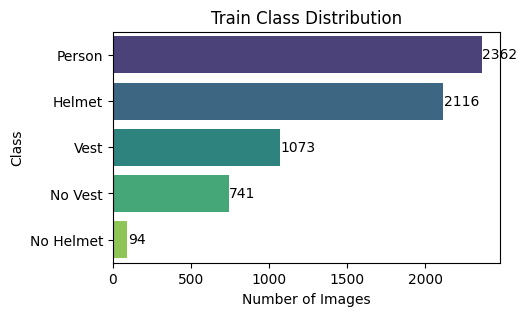



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



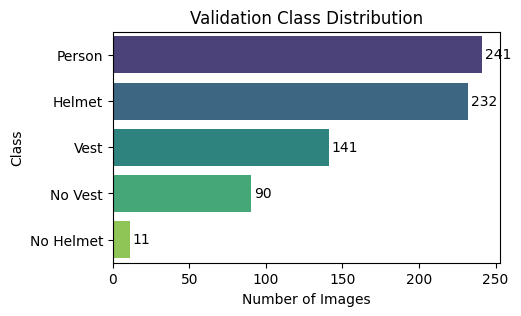



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



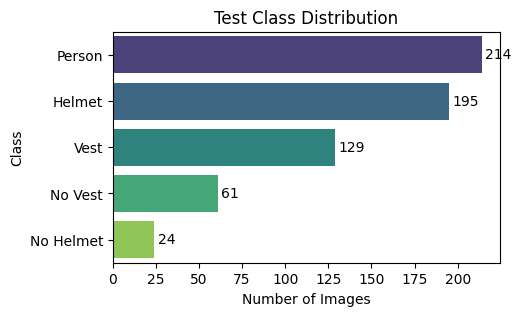

In [19]:
# Check the distribution of classes in the dataset

def get_class_distribution(split='train',):
    labels_dir = os.path.join(DATASET_PATH, split, 'labels')

    class_distribution = {class_name: 0 for class_name in CLASS_MAP.values()}   
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split(' ')
                class_id = int(float(parts[0]))
                class_name = CLASS_MAP.get(class_id, 'Unknown')
                class_distribution[class_name] += 1

    return class_distribution

train_class_distribution = get_class_distribution(split='train')
val_class_distribution = get_class_distribution(split='valid')
test_class_distribution = get_class_distribution(split='test')

# visualize the class distribution
def plot_class_distribution(class_distribution, title):
    class_names, class_counts = zip(*sorted(class_distribution.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(5, 3))
    sns.barplot(x=class_counts, y=class_names, palette="viridis")
    plt.xlabel("Number of Images")
    plt.ylabel("Class")
    plt.title(title)

    # Add text labels on bars
    for i, v in enumerate(class_counts):
        plt.text(v + 2, i, str(v), va='center')

    plt.show()

# Plot with improved visualization
plot_class_distribution(train_class_distribution, "Train Class Distribution")
plot_class_distribution(val_class_distribution, "Validation Class Distribution")
plot_class_distribution(test_class_distribution, "Test Class Distribution")

"No Vest" and "No Helmet" classes are underrepresented. Data augmentation is needed.
I will create sepearte folders for the augmented data.

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.2), 
    A.Rotate(limit=20, p=0.5), 
    A.MotionBlur(blur_limit=3, p=0.2),
    A.RandomResizedCrop(size=(640, 640), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [24]:
AUG_IMAGES_DIR = os.path.join(DATASET_PATH, 'augmented_train/images')
AUG_LABELS_DIR = os.path.join(DATASET_PATH, 'augmented_train/labels')
os.makedirs(AUG_IMAGES_DIR, exist_ok=True)
os.makedirs(AUG_LABELS_DIR, exist_ok=True)

In [25]:
RARE_CLASSES = ['No Helmet', 'No Vest']

def augment_image(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    # load bounding boxes

    bboxes = []
    labels = []
    no_helmet = False
    no_vest = False

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split(' ')
                class_id = int(float(parts[0]))
                x_center, y_center, w, h = map(float, parts[1:])
                bboxes.append([x_center, y_center, w, h])
                labels.append(class_id)


                if class_id  == 1:
                    no_helmet = True
                elif class_id == 2:
                    no_vest = True  
    
    num_augments = 8 if no_helmet else (3 if no_vest else 1)   # Less augmentation for common classes

    # Apply augmentations

    for i in range(num_augments):
        augmented = augmentations(image=img, bboxes=bboxes, class_labels=labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']   
        aug_labels = augmented['class_labels']

        # save augmented image
        new_image_name = f"aug_{i}_{os.path.basename(image_path)}"
        new_image_path = os.path.join(AUG_IMAGES_DIR, new_image_name)
        cv2.imwrite(new_image_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        new_label_name = new_image_name.replace(".jpg", ".txt").replace(".png", ".txt")
        with open(os.path.join(AUG_LABELS_DIR, new_label_name), "w") as f:
            for bbox, label in zip(aug_bboxes, aug_labels):
                f.write(f"{label} {' '.join(map(str, bbox))}\n")


In [26]:
for img_name in os.listdir(IMAGES_DIR):
    img_path = os.path.join(IMAGES_DIR, img_name)
    label_path = os.path.join(LABELS_DIR, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    if os.path.exists(label_path):
        augment_image(img_path, label_path)

print("Augmentation complete")

Augmentation complete




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



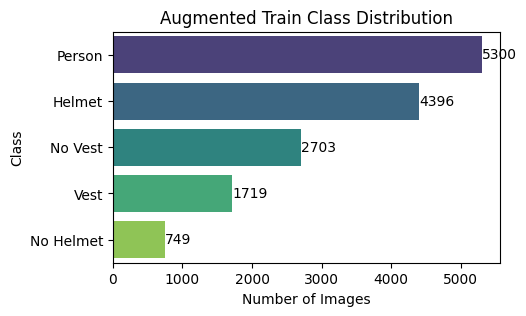

In [27]:
aug_train_class_distribution = get_class_distribution(split='augmented_train')
plot_class_distribution(aug_train_class_distribution, "Augmented Train Class Distribution")


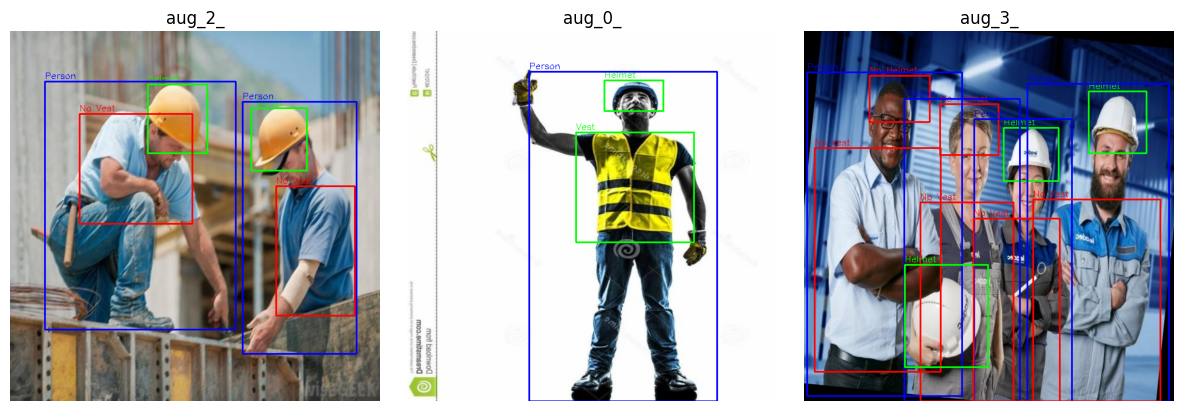

In [28]:
visualize_batch_on_grid(split='augmented_train', num_images=3)